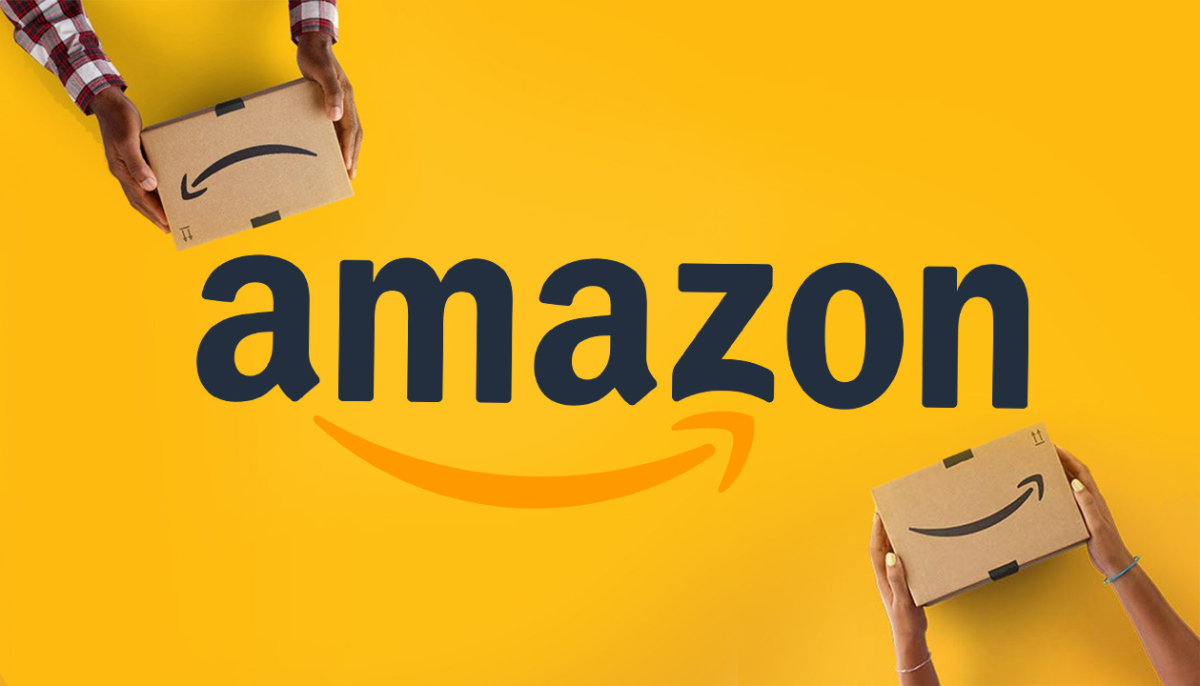

## To buy or not to buy is the question...

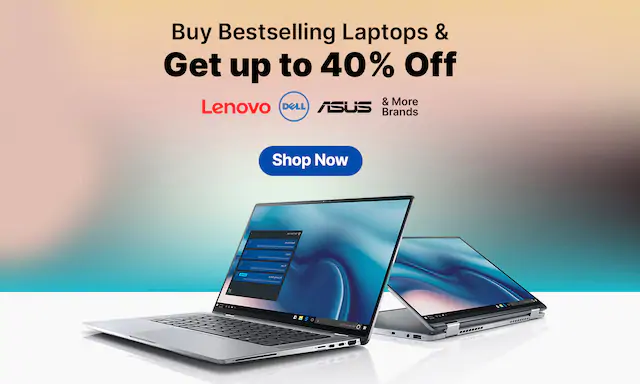

## To recommend is the answer ...

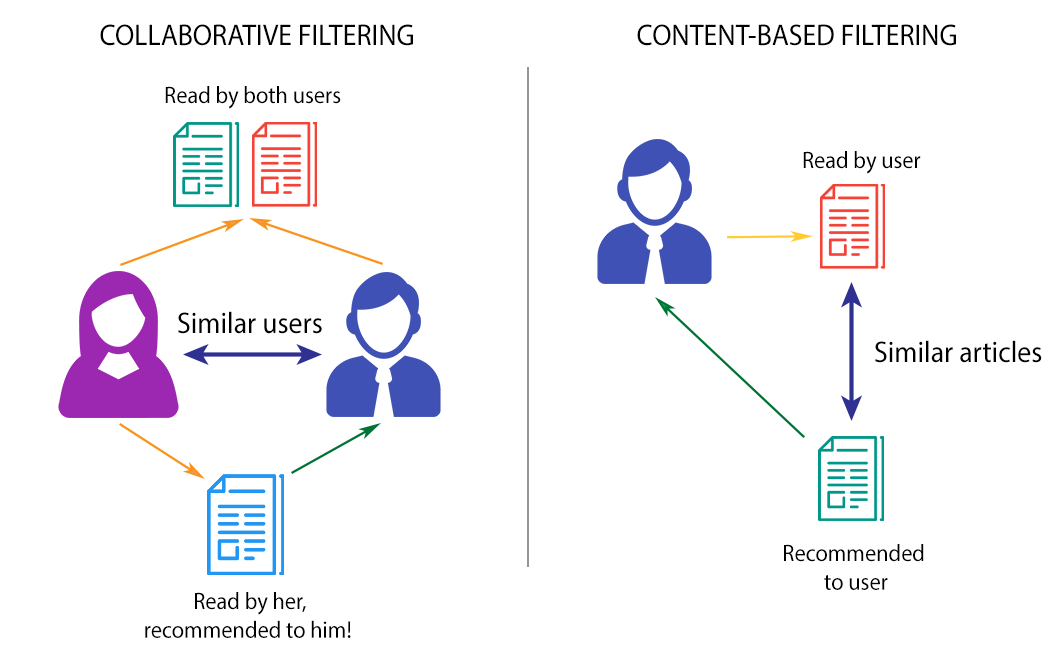

![](https://www.theindianwire.com/business/amazon-prime-online-nets-over-4000-sellers-millions-in-2-days-282475/)

# Recommendation Systems on Amazon electronic data  

## Data Description:  

Amazon Reviews data (data source) The repository has several datasets. For this case study, we are using the Electronics dataset.

## Domain: 
E-commerce

## Context: 
Online E-commerce websites like Amazon, Flipkart uses different recommendation models to provide different suggestions to different users. Amazon currently uses item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time. 
#### Attribute Information: 
#### ● userId  : Every user identified with a unique id 
#### ● productId : Every product identified with a unique id \n 
#### ● Rating  : Rating of the corresponding product by the corresponding user  
#### ● timestamp : Time of the rating ( ignore this column for this exercise) 

## Learning Outcomes:  
#### ● Exploratory Data Analysis 
#### ● Creating a Recommendation system using real data 
#### ● Collaborative filtering  

## Objective:  

Build a recommendation system to recommend products to customers based on the their  previous ratings for other products. 

## Steps and tasks: 

#### 1. Read and explore the given dataset.  (Rename column/add headers, plot histograms, find data characteristics) 
#### 2. Take a subset of the dataset to make it less sparse/ denser. ( For example, keep the users only who has given 50 or more number of ratings )  
#### 3. Split the data randomly into train and test dataset. ( For example, split it in 70/30 ratio) 
#### 4. Build Popularity Recommender model.  
#### 5. Build Collaborative Filtering model. 
#### 6. Evaluate both the models. ( Once the model is trained on the training data, it can be used to compute the error (RMSE) on predictions made on the test data.  
#### 7. Get top - K ( K = 5) recommendations. Since our goal is to recommend new products for each user based on his/her habits, we will recommend 5 new products.  
#### 8. Summarise your insights.  



## 0. Import necessary libraries

In [ ]:
#Import the necessary libraries(This was run on Kaggle as Colabs was crashing and getting disconnected)
import numpy as np
import pandas as pd
import seaborn as sns
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
#from google.colab import drive
#import os
#drive.mount('/content/drive',force_remount=True)

In [ ]:
#Change to the drive location having the data file
#os.chdir('/content/drive/My Drive')

## 1. Read the input file

#### Read the csv file and assign column names as per problem statement description

In [ ]:
#Read the csv file and assign column names as per problem statement description
ratings = pd.read_csv("../input/amazon-electronics-data/ratings_Electronics.csv",
                      names=['userId', 'productId','Rating','timestamp'])

#### Check data snapshot to see if everything looks fine, timestamp column needs to be dropped later on

In [ ]:
#Check data snapshot to see if everything looks fine, timestamp column needs to be dropped later on
ratings.head()

#### Number of rows is 7.82MM and number of columns is 4

In [ ]:
#Number of rows is 7.82MM and number of columns is 4
ratings.shape

#### Check the datatypes
#### userID, productID are object while Rating is float, timestamp is integer

In [ ]:
#Check the datatypes
#userID, productID are object while Rating is float, timestamp is integer
ratings.dtypes

#### The dataset is utilizing almost 240MB of disk space due to 7.82MM rows and 4 columns
#### There will be memory issues unless we make the dataset more dense

In [ ]:
#The dataset is utilizing almost 240MB of disk space due to 7.82MM rows and 4 columns
#There will be memory issues unless we make the dataset more dense
ratings.info()

#### Countplot of the ratings, maximum user-products have got rating as 5 

In [ ]:
#Countplot of the ratings, maximum user-products have got rating as 5 
sns.countplot(data=ratings, x='Rating');
#ratings["Rating"].value_counts().sort_values(ascending=False).plot(kind="bar")

#### Find the minimum and maximum ratings - It is between 1 and 5

In [ ]:
#Find the minimum and maximum ratings - It is between 1 and 5
print('Minimum rating is: %d' %(ratings.Rating.min()))
print('Maximum rating is: %d' %(ratings.Rating.max()))

#### Check for missing values - There are no missing values, so no imputation required

In [ ]:
#Check for missing values - There are no missing values, so no imputation required
print('Number of missing values across columns: \n',ratings.isna().sum())

#### Number of products (476K) is less than number of users(4.2MM), so item-item colaborative filtering would make sense
#### instead of user-user colaborative filtering

In [ ]:
#Number of products (~476K) is less than number of users(~4.2MM), so item-item colaborative filtering would make sense
#instead of user-user colaborative filtering
print("Electronic Data Summary")
print("="*100)
print("\nTotal # of Ratings :",ratings.shape[0])
print("Total # of Users   :", len(np.unique(ratings.userId)))
print("Total # of Products  :", len(np.unique(ratings.productId)))
print("\n")
print("="*100)

#### Dropping the Timestamp column

In [ ]:
#Dropping the Timestamp column
ratings.drop(['timestamp'], axis=1,inplace=True)

#### Check and find the max and min ratings given by user for a particular item

In [ ]:
#Check and find the max ratings given by user for a particular item
max_ratings = ratings.groupby(['userId','productId'])['Rating'].max().sort_values(ascending=False)

In [ ]:
max_ratings.head()

In [ ]:
#Check and find the min ratings given by user for a particular item
min_ratings = ratings.groupby(['userId','productId'])['Rating'].min().sort_values(ascending=False)

In [ ]:
min_ratings.head()

#### From above min and max calculation, we see that the ratings are identical for the sample
#### However for consistency let us remove duplicates if any just to be sure

In [ ]:
#From above min and max calculation, we see that the ratings are identical for the sample
#However for consistency let us remove duplicates if any just to be sure
ratings.drop_duplicates(inplace=True)

#### Analysis of how many product rating given by a particular user 

In [ ]:
#Analysis of how many product rating given by a particular user 
no_of_rated_products_per_user = ratings.groupby(by='userId')['Rating'].count().sort_values(ascending=False)
no_of_rated_products_per_user.head()

#### We have certain users who have rated only 1 product and few users have rated upto 520 products
#### However the number of rated products per user is fairly skewed seeing the 5 point summary
#### Max is 520 and 75% percentile is at 2

In [ ]:
#We have certain users who have rated only 1 product and few users have rated upto 520 products
#However the number of rated products per user is fairly skewed seeing the 5 point summary
#Max is 520 and 75% percentile is at 2
no_of_rated_products_per_user.describe().astype(int).T

#### Boxplot shows that we have few users who rate many items (appearing in outliers) but majority rate very few items


In [ ]:
#Boxplot shows that we have few users who rate many items (appearing in outliers) but majority rate very few items
sns.boxplot(data=no_of_rated_products_per_user);

#### Let us look at the quantile view to understand where the ratings are concentrated

In [ ]:
#Let us look at the quantile view to understand where the ratings are concentrated
quantiles = no_of_rated_products_per_user.quantile(np.arange(0,1.01,0.01), interpolation='higher')

#### We can see that all the ratings are clustered at the top end of the quantile
#### Basically the outliers that we saw earlier are reflected here in the peak

In [ ]:
#We can see that all the ratings are clustered at the top end of the quantile
#Basically the outliers that we saw earlier are reflected here in the peak
plt.figure(figsize=(10,10))
plt.title("Quantiles and their Values")
quantiles.plot()
# quantiles with 0.05 difference
plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='red', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='green', label = "quantiles with 0.25 intervals")
plt.ylabel('# ratings by user')
plt.xlabel('Value at the quantile')
plt.legend(loc='best')
plt.show()

#### We have 1,540 users who have rated more than or equal to 50 products

In [ ]:
#We have 1,540 users who have rated more than or equal to 50 products
print('\n # of rated product more than 50 per user : {}\n'.format(sum(no_of_rated_products_per_user >= 50)) )

#### Getting the new dataframe which contains users who has given 50 or more ratings

In [ ]:
#Getting the new dataframe which contains users who has given 50 or more ratings
new_df=ratings.groupby("userId").filter(lambda x:x['Rating'].count() >=50)

#### Products also have skewed ratings with majority of the products having very few ratings


In [ ]:
#Products also have skewed ratings with majority of the products having very few ratings
no_of_ratings_per_product = new_df.groupby(by='productId')['Rating'].count().sort_values(ascending=False)

fig = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()
plt.plot(no_of_ratings_per_product.values)
plt.title('# RATINGS per Product')
plt.xlabel('Product')
plt.ylabel('# ratings per product')
ax.set_xticklabels([])

plt.show

#### Boxplot shows that we have few products with large number of ratings, but majority have very low ratings


In [ ]:
#Boxplot shows that we have few products with large number of ratings, but majority have very low ratings
sns.boxplot(data=no_of_ratings_per_product);

#### Let us look at the quantile view to understand where the ratings are concentrated


In [ ]:
#Let us look at the quantile view to understand where the ratings are concentrated
quantiles = no_of_ratings_per_product.quantile(np.arange(0,1.01,0.01), interpolation='higher')

#### We can see that all the ratings are clustered at the top end of the quantile
#### This reflects our finding above in the boxplot

In [ ]:
#We can see that all the ratings are clustered at the top end of the quantile
#This reflects our finding above in the boxplot
plt.figure(figsize=(10,10))
plt.title("Quantiles and their Values")
quantiles.plot()
# quantiles with 0.05 difference
plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='red', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='green', label = "quantiles with 0.25 intervals")
plt.ylabel('# ratings by user')
plt.xlabel('Value at the quantile')
plt.legend(loc='best')
plt.show()

#### Average rating of the product across users

In [ ]:
#Average rating of the product across users
new_df.groupby('productId')['Rating'].mean().head()

In [ ]:
new_df.groupby('productId')['Rating'].mean().sort_values(ascending=False).head()

#### Descriptive statistics on the ratings

In [ ]:
#Total no of rating for product
new_df.groupby('productId')['Rating'].count().sort_values(ascending=False).head()

In [ ]:
ratings_mean_count = pd.DataFrame(new_df.groupby('productId')['Rating'].mean())

In [ ]:
ratings_mean_count['rating_counts'] = pd.DataFrame(new_df.groupby('productId')['Rating'].count())

In [ ]:
#Products which have high rating have fewer user reviews as seen below
ratings_mean_count.head()

#### The maximum number of ratings received for a product is 206

In [ ]:
#The maximum number of ratings received for a product is 206
ratings_mean_count['rating_counts'].max()

#### Majority of the products have received 1 rating only and it is a right skewed distribution

In [ ]:
#Majority of the products have received 1 rating only and it is a right skewed distribution
plt.figure(figsize=(8,6))
#plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['rating_counts'].hist(bins=100)

#### We see a left skewed distribution for the ratings
#### There are clusters at each of the points 1,2,3,4,5 as that is where the means are concentrated


In [ ]:
#We see a left skewed distribution for the ratings
#There are clusters at each of the points 1,2,3,4,5 as that is where the means are concentrated
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['Rating'].hist(bins=100)

#### From the joint plot below it seems that popular products (higher ratings) tend to be rated more frequently
#### To make people more engaged (bottom of the chart) we can start by recommending them based on popularity based system and then slowly graduate them to collaborative system once we have sufficient number of data points to giver personlized recommendation


In [ ]:
#From the joint plot below it seems that popular products (higher ratings) tend to be rated more frequently
#To make people more engaged (bottom of the chart) we can start by recommending them based on popularity based system and then
#slowly graduate them to collaborative system once we have sufficient number of data points to giver personlized recommendation
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
sns.jointplot(x='Rating', y='rating_counts', data=ratings_mean_count, alpha=0.4)

#### PDF (Probability distribution function) and CDF (Cumulative distribution function) for the number of ratings per product
#### PDF is left skewed as majority of the products have very few ratings

In [ ]:
#PDF and CDF for the number of ratings per product
#PDF is left skewed as majority of the products have very few ratings
ax1 = plt.subplot(121)
sns.kdeplot(no_of_ratings_per_product, shade=True, ax=ax1)
plt.xlabel('No of ratings by product')
plt.title("PDF")

ax2 = plt.subplot(122)
sns.kdeplot(no_of_ratings_per_product, shade=True, cumulative=True,ax=ax2)
plt.xlabel('No of ratings by product')
plt.title('CDF')

plt.show()

In [ ]:
no_of_ratings_per_user = new_df.groupby(by='userId')['Rating'].count().sort_values(ascending=False)

#### PDF and CDF for the number of ratings per user
#### PDF is left skewed as majority of the users have given very few ratings

In [ ]:
#PDF and CDF for the number of ratings per user
#PDF is left skewed as majority of the users have given very few ratings
ax1 = plt.subplot(121)
sns.kdeplot(no_of_ratings_per_user, shade=True, ax=ax1)
plt.xlabel('No of ratings by user')
plt.title("PDF")

ax2 = plt.subplot(122)
sns.kdeplot(no_of_ratings_per_user, shade=True, cumulative=True,ax=ax2)
plt.xlabel('No of ratings by user')
plt.title('CDF')

plt.show()

#### Below is the bar graph showing product list of top 30 most popular products

In [ ]:
#Below is the bar graph showing product list of top 30 most popular products
popular_products = pd.DataFrame(new_df.groupby('productId')['Rating'].count())
most_popular = popular_products.sort_values('Rating', ascending=False)
most_popular.head(30).plot(kind = "bar")

# 3. Popularity Based Method

#### Split the data into 70% train and 30% test

In [ ]:
#Split the data into 70% train and 30% test
train_data, test_data = train_test_split(new_df, test_size = 0.30, random_state=0)
print(train_data.head(5))

#### Count of user_id for each unique product as recommendation score 

In [ ]:
#Count of user_id for each unique product as recommendation score 
train_data_grouped = train_data.groupby('productId').agg({'userId': 'count'}).reset_index()
train_data_grouped.rename(columns = {'userId': 'score'},inplace=True)
train_data_grouped.head()

#### Sort the products on recommendation score 
#### Get the top 5 recommendations

In [ ]:
#Sort the products on recommendation score 
train_data_sort = train_data_grouped.sort_values(['score', 'productId'], ascending = [0,1])     
#Generate a recommendation rank based upon score 
train_data_sort['Rank'] = train_data_sort['score'].rank(ascending=0, method='first') 
#Get the top 5 recommendations 
popularity_recommendations = train_data_sort.head(5) 
popularity_recommendations 

#### Use popularity based recommender model to make predictions for a user
#### As we note this list will be same for all the users

In [ ]:
# Use popularity based recommender model to make predictions for a user
# As we note this list will be same for all the users
def recommend(user_id):     
    user_recommendations = popularity_recommendations 
          
    #Add user_id column for which the recommendations are being generated 
    user_recommendations['userId'] = user_id 
      
    #Bring user_id column to the front 
    cols = user_recommendations.columns.tolist() 
    cols = cols[-1:] + cols[:-1] 
    user_recommendations = user_recommendations[cols] 
          
    return user_recommendations 

#### This list is user choice, since this is popularity based recommendation method irrespective of user same products will be suggested


In [ ]:
# This list is user choice, since this is popularity based recommendation method irrespective of user 
# same products will be suggested
find_recom = ['A15BHBF0L0HV1F','A3VVJIZXLL1QFP','AFHY3XJJ6NCAI','A2WPY1SNQPCC00','AJMJREC90WJVP']   
for i in find_recom:
    print("Here is the recommendation for the userId: %s\n" %(i))
    print(recommend(i))    
    print("\n") 

In [ ]:
train_data_sort.head()
#print(pred)

In [ ]:
test_data.head()

#### Calculating the RMSE of the popularity based recommendation system
#### Rating present in the test data is the actual rating (Act_rating)

In [ ]:
#Calculating the RMSE of the popularity based recommendation system
#Rating present in the test data is the actual rating (Act_rating)
test_data2 = test_data.copy()
#ratings.drop(['timestamp'], axis=1,inplace=True)
test_data2.drop(['userId'],axis=1,inplace=True)
test_data2.rename(columns = {'Rating':'Act_rating'}, inplace = True)

In [ ]:
test_data2.head()

#### Count of user_id for each unique product as recommendation score 

In [ ]:
#Count of user_id for each unique product as recommendation score 
train_data_grouped2 = train_data.groupby('productId').agg({'Rating': 'sum'}).reset_index()
train_data_grouped2.rename(columns = {'Rating': 'Sum_rating'},inplace=True)
train_data_grouped2.head()

In [ ]:
train_data_inner = pd.merge(train_data_grouped2, train_data_sort)

In [ ]:
train_data_inner.head()

#### Obtain the average rating of the product across users

In [ ]:
#Obtain the average rating of the product across users
train_data_inner["Avg_Rating"] = train_data_inner["Sum_rating"]/train_data_inner["score"]

In [ ]:
train_data_inner.head()

#### Merge the train data having average rating with the test data having actual rating at product level

In [ ]:
#Merge the train data having average rating with the test data having actual rating at product level
test_data_inner = pd.merge(train_data_inner, test_data2)

In [ ]:
test_data_inner.head()

#### Now the merged data has both actual rating (Act_rating) and predicted rating (Avg_rating)
#### Now RMSE can be calculated

In [ ]:
#Now the merged data has both actual rating (Act_rating) and predicted rating (Avg_rating)
#Now RMSE can be calculated
test_data_inner.head()

#### RMSE for popularity based recommender system is 1.09

In [ ]:
#RMSE for popularity based recommender system is 1.09
mse = mean_squared_error(test_data_inner["Act_rating"], test_data_inner["Avg_Rating"])
rmse = math.sqrt(mse)
print("RMSE for popularity based recommendation system:", rmse)

In [ ]:
ratings.head()

#### Upgrading pip as pakage update for turicreate was giving issues

In [ ]:
#Upgrading pip as pakage update for turicreate was giving issues
!pip install --upgrade pip

In [ ]:
!pip install -U --use-feature=2020-resolver turicreate

#### Importing turicreate
#### This package takes SFrame instead of dataframe so typecasting accordingly

In [ ]:
#Importing turicreate
#This package takes SFrame instead of dataframe so typecasting accordingly
import turicreate
train_data2 = turicreate.SFrame(train_data)
test_data2 = turicreate.SFrame(test_data)

#### Build the popularity recommender system 

In [ ]:
#Build the popularity recommender system 
popularity_model = turicreate.popularity_recommender.create(train_data2, user_id='userId', item_id='productId', target='Rating')

#### Recommend for a given set of users, since there are top 5 recommendation for 5 users, total rows will be 25


In [ ]:
#Recommend for a given set of users, since there are top 5 recommendation for 5 users, total rows will be 25
popularity_recomm = popularity_model.recommend(users=['AKM1MP6P0OYPR',
'A2CX7LUOHB2NDG',
'A2NWSAGRHCP8N5',
'A2WNBOD3WNDNKT',
'A1GI0U4ZRJA8WN'],k=5)
popularity_recomm.print_rows(num_rows=25)

In [ ]:
#m = turicreate.recommender.create(train_data2, user_id='userId', item_id='productId', target='Rating')
pop_rmse = popularity_model.evaluate_rmse(test_data2,'Rating')

#### Get the rmse value which is 1.11 in this case

In [ ]:
#Get the rmse value
print(pop_rmse)

In [ ]:
#The RMSE value is 1.11 for the popularity based model
pop_rmse["rmse_overall"]

# 4.Item-Item based method

#### Training the model for item-item similarity recommender

In [ ]:
#Training the model for item-item similarity recommender
item_sim_model = turicreate.item_similarity_recommender.create(train_data2, user_id='userId', item_id='productId', target='Rating', similarity_type='cosine')

#### Making top 5 recommendations based on item-item similarity recommender system

In [ ]:
#Making top 5 recommendations based on item-item similarity recommender system
item_sim_recomm = item_sim_model.recommend(users=['AKM1MP6P0OYPR',
'A2CX7LUOHB2NDG',
'A2NWSAGRHCP8N5',
'A2WNBOD3WNDNKT',
'A1GI0U4ZRJA8WN'],k=5)
item_sim_recomm.print_rows(num_rows=25)

#### Get the item-item recommender RMSE value, value is 4.39 which is much worse than popularity based recommender system


In [ ]:
#Get the item-item recommender RMSE value, value is 4.39 which is much worse than popularity based recommender system
item_rmse = item_sim_model.evaluate_rmse(test_data2,'Rating')

In [ ]:
#for key in pop_rmse2.keys():
#    print(key, '->', pop_rmse2[key])
item_rmse["rmse_overall"]

# 5.Matrix based factorization model
#### Build a matrix based factorization model

In [ ]:
#Build a matrix based factorization model recommender system
factorization_model = turicreate.factorization_recommender.create(train_data2, user_id='userId', item_id='productId', target='Rating')


#### Recommend top 5 products for 5 users basis matrix factorization method

In [ ]:
#Recommend top 5 products for 5 users basis matrix factorization method
factorization_recomm = factorization_model.recommend(users=['AKM1MP6P0OYPR',
'A2CX7LUOHB2NDG',
'A2NWSAGRHCP8N5',
'A2WNBOD3WNDNKT',
'A1GI0U4ZRJA8WN'],k=5)
factorization_recomm.print_rows(num_rows=25)

In [ ]:
fcm_rmse2 = factorization_model.evaluate_rmse(test_data2,'Rating')

#### Matrix factorization has a better RMSE than item-item recommender but little worse than popularity based recommender system


In [ ]:
#Matrix factorization has a better RMSE than item-item recommender but little worse than popularity based recommender system
fcm_rmse2["rmse_overall"]

#### Importing Surprise and relevant packages to do some hyper parameter tuning through Grid Search

In [ ]:
#Importing Surprise and relevant packages to do some hyper parameter tuning through Grid Search
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV
from surprise import KNNBasic, KNNWithMeans, KNNWithZScore
from surprise import SVD, SVDpp, NMF
from surprise import SlopeOne, CoClustering

In [ ]:
rts_gp = ratings.groupby(by=['Rating']).agg({'userId': 'count'}).reset_index()
rts_gp.columns = ['Rating', 'Count']

#### We can see that majority have rated products in the higher range

In [ ]:
#We can see that majority have rated products in the higher range
plt.barh(rts_gp.Rating, rts_gp.Count, color='royalblue')
plt.title('Overall Count of Ratings', fontsize=15)
plt.xlabel('Count', fontsize=15)
plt.ylabel('Rating', fontsize=15)
plt.grid(ls='dotted')
plt.show()

#### Subsetting the data to keep products having at least 100 ratings

In [ ]:
#Subsetting the data to keep products having at least 100 ratings
prod_ge_100=ratings.groupby("productId").filter(lambda x:x['Rating'].count() >= 100)

In [ ]:
prod_ge_100.head()

#### Subsetting the data to keep users who have given at least 100 ratings

In [ ]:
#Subsetting the data to keep users who have given at least 100 ratings
user_ge_100=ratings.groupby("userId").filter(lambda x:x['Rating'].count() >= 100)

In [ ]:
user_ge_100.head()

In [ ]:
user_ge_100.drop(['Rating'],inplace=True,axis=1)

In [ ]:
user_prod_ge_100 = pd.merge(prod_ge_100,user_ge_100)

#### Merging the datasets to get data where each product has atleast 100 ratings and each user has given atleast 100 ratings
#### This makes the matrix more dense and also allows GridSearch algo to run, else it is failing
#### Taking a 10% random sample with full data as the SVD decomposition is failing

#### * Use K nearest neighbour (basic, with means, and normalized (z-score))
#### * Support Vector Decomposition (SVD)
#### * Co-clustering

In [ ]:
#Merging the datasets to get data where each product has atleast 100 ratings and each user has given atleast 100 ratings
#This makes the matrix more dense and also allows GridSearch algo to run, else it is failing
user_prod_ge_100.shape

In [ ]:
#Taking a 10% random sample with full data as the SVD decomposition is failing
new_df2 = user_prod_ge_100.sample(frac=0.1, replace=False, random_state=0)

In [ ]:
#train_data.shape

In [ ]:
# Set Rating Scale from 1 to 5
#We are running basic algorithms to check which one works best
reader = Reader(rating_scale=(1, 5))

# Load data with rating scale
#data = Dataset.load_from_df(new_df, reader)
data = Dataset.load_from_df(new_df2,reader)

In [ ]:
knnbasic_cv = cross_validate(KNNBasic(), data, cv=5, n_jobs=5, verbose=False)
knnmeans_cv = cross_validate(KNNWithMeans(), data, cv=5, n_jobs=5, verbose=False)
knnz_cv = cross_validate(KNNWithZScore(), data, cv=5, n_jobs=5, verbose=False)

In [ ]:
svd_cv = cross_validate(SVD(), data, cv=5, n_jobs=5, verbose=False)
svdpp_cv = cross_validate(SVDpp(), data, cv=5, n_jobs=5, verbose=False)
nmf_cv = cross_validate(NMF(), data, cv=5, n_jobs=5, verbose=False)

In [ ]:
slope_cv = cross_validate(SlopeOne(), data, cv=5, n_jobs=5, verbose=False)
coclus_cv = cross_validate(CoClustering(), data, cv=5, n_jobs=5, verbose=False)

In [ ]:
print('Algorithm\t RMSE\t\t MAE')
print()
print('KNN Basic', '\t', round(knnbasic_cv['test_rmse'].mean(), 4), '\t', round(knnbasic_cv['test_mae'].mean(), 4))
print('KNN Means', '\t', round(knnmeans_cv['test_rmse'].mean(), 4), '\t', round(knnmeans_cv['test_mae'].mean(), 4))
print('KNN ZScore', '\t', round(knnz_cv['test_rmse'].mean(), 4), '\t', round(knnz_cv['test_mae'].mean(), 4))
print()
print('SVD', '\t\t', round(svd_cv['test_rmse'].mean(), 4), '\t', round(svd_cv['test_mae'].mean(), 4))
print('SVDpp', '\t\t', round(svdpp_cv['test_rmse'].mean(), 4), '\t', round(svdpp_cv['test_mae'].mean(), 4))
print('NMF', '\t\t', round(nmf_cv['test_rmse'].mean(), 4), '\t', round(nmf_cv['test_mae'].mean(), 4))
print()
print('SlopeOne', '\t', round(slope_cv['test_rmse'].mean(), 4), '\t', round(slope_cv['test_mae'].mean(), 4))
print('CoClustering', '\t', round(coclus_cv['test_rmse'].mean(), 4), '\t', round(coclus_cv['test_mae'].mean(), 4))
print()

In [ ]:
x_algo = ['KNN Basic', 'KNN Means', 'KNN ZScore', 'SVD', 'SVDpp', 'NMF', 'SlopeOne', 'CoClustering']
all_algos_cv = [knnbasic_cv, knnmeans_cv, knnz_cv, svd_cv, svdpp_cv, nmf_cv, slope_cv, coclus_cv]

rmse_cv = [round(res['test_rmse'].mean(), 4) for res in all_algos_cv]
mae_cv = [round(res['test_mae'].mean(), 4) for res in all_algos_cv]

plt.figure(figsize=(20,5))

plt.subplot(1, 2, 1)
plt.title('Comparison of Algorithms on RMSE', loc='center', fontsize=15)
plt.plot(x_algo, rmse_cv, label='RMSE', color='darkgreen', marker='o')
plt.xlabel('Algorithms', fontsize=15)
plt.ylabel('RMSE Value', fontsize=15)
plt.legend()
plt.grid(ls='dashed')

plt.subplot(1, 2, 2)
plt.title('Comparison of Algorithms on MAE', loc='center', fontsize=15)
plt.plot(x_algo, mae_cv, label='MAE', color='navy', marker='o')
plt.xlabel('Algorithms', fontsize=15)
plt.ylabel('MAE Value', fontsize=15)
plt.legend()
plt.grid(ls='dashed')

plt.show()

In [ ]:
# Parameter space
svd_param_grid = {'n_epochs': [20, 25], 
                  'lr_all': [0.007, 0.009, 0.01],
                  'reg_all': [0.4, 0.6]}

svdpp_gs = GridSearchCV(SVDpp, svd_param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=5)
svdpp_gs.fit(data)

svd_gs = GridSearchCV(SVD, svd_param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=5)
svd_gs.fit(data)

In [ ]:
print('SVDpp - RMSE:', round(svdpp_gs.best_score['rmse'], 4), '; MAE:', round(svdpp_gs.best_score['mae'], 4))
print('SVD   - RMSE:', round(svd_gs.best_score['rmse'], 4), '; MAE:', round(svd_gs.best_score['mae'], 4))

In [ ]:
print('RMSE =', svdpp_gs.best_params['rmse'])
print('MAE =', svdpp_gs.best_params['mae'])

In [ ]:
print('RMSE =', svd_gs.best_params['rmse'])
print('MAE =', svd_gs.best_params['mae'])

In [ ]:
param_grid = {'k': [15, 20, 25, 30, 40, 50, 60]}

knnbasic_gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=5)
knnbasic_gs.fit(data)

knnmeans_gs = GridSearchCV(KNNWithMeans, param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=5)
knnmeans_gs.fit(data)

knnz_gs = GridSearchCV(KNNWithZScore, param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=5)
knnz_gs.fit(data)

In [ ]:
x = [15, 20, 25, 30, 40, 50, 60]
y1 = knnbasic_gs.cv_results['mean_test_rmse']
y2 = knnbasic_gs.cv_results['mean_test_mae']

y3 = knnmeans_gs.cv_results['mean_test_rmse']
y4 = knnmeans_gs.cv_results['mean_test_mae']

y5 = knnz_gs.cv_results['mean_test_rmse']
y6 = knnz_gs.cv_results['mean_test_mae']

In [ ]:
plt.figure(figsize=(18,5))

plt.subplot(1, 2, 1)
plt.title('K Neighbors vs RMSE', loc='center', fontsize=15)
plt.plot(x, y1, label='KNNBasic', color='lightcoral', marker='o')
plt.plot(x, y5, label='KNNWithZScore', color='indianred', marker='o')
plt.plot(x, y3, label='KNNWithMeans', color='darkred', marker='o')
plt.xlabel('K Neighbor', fontsize=15)
plt.ylabel('RMSE Value', fontsize=15)
plt.legend()
plt.grid(ls='dotted')

plt.subplot(1, 2, 2)
plt.title('K Neighbors vs MAE', loc='center', fontsize=15)
plt.plot(x, y2, label='KNNBasic', color='lightcoral', marker='o')
plt.plot(x, y4, label='KNNWithMeans', color='indianred', marker='o')
plt.plot(x, y6, label='KNNWithZScore', color='darkred', marker='o')
plt.xlabel('K Neighbor', fontsize=15)
plt.ylabel('MAE Value', fontsize=15)
plt.legend()
plt.grid(ls='dotted')

plt.show()

#### We have made both popularity and collaborative recommendation system here
#### Popularity based system had RMSE of 1.09 while collaborative item-item based system had RMSE of 4.39
#### So the collaborative item-item based recommendation system was worse although 
#### we had to create a more dense matrix.The matrix factorization gave RMSE of 1.16
#### This shows that popularity based and matrix factorization based system are comparable if 
#### user ratings are skewed to few items only
#### For the rest of the portfolio we can have popularity based recommendations as they are not that
#### much engaged with electronic products
#### The dense matrix consists of users who have rated atlest 50 products and products having at least 50 ratings
#### This was done to avoid system crashes and restrict the recommendation to the top users for 
#### for multiple models as it is computation intensive
#### We can also use hyperparameter tuning to get better results in terms of RMSE 
#### Further improvement can be made by doing GridSearchCV or RandomSearchCV to understand what is
#### the best k to reduce RMSE
#### We are not able to plot distortion vs K value as Surprise package converts dataframe into a different format
#### However with grid search we see that there is not much difference with k values for k means
#### SVD gives much better results in turns of RMSE as seen from the charts above ->0.93

#### Reference function to get top n recommendations

In [ ]:
from collections import defaultdict
def get_top_n(predictions, n=5):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 5.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n